In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import datasets, model_selection
from sklearn.metrics import log_loss 

train= pd.read_csv('train4.csv')

#train4.csv 결측치행, index 열 제거
train.dropna(inplace=True)
train.drop(['Unnamed: 0'], axis=1, inplace=True)

# 성별 분류
train['gender'] = train['gender'].replace(['F','M'],[0,1])

# 차량 소유 분류
train['car'] = train['car'].replace(['N','Y'],[0,1])

# 부동산(주택) 소유 분류
train['reality'] = train['reality'].replace(['N','Y'],[0,1])
train['family_type'] = train['family_type'].replace(['Married','Civil marriage','Single / not married','Separated','Widow'],[1,1,0,0,0])

train.loc[train['family_size'] >= 5,'family_size']=5

# child 유무 
train.loc[train['child_num'] >= 1,'child_num']=1

train['age'] = train['DAYS_BIRTH']*(-1)/365
train['age'] = train['age'].round(0)

# train['begin_month'] = train['begin_month']* -1
# train.loc[train['DAYS_EMPLOYED'] >0,'DAYS_EMPLOYED']=0
# train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED']* -1
train.drop(['DAYS_BIRTH'],axis=1,inplace=True)

train['age']= -train['age']
# test['age']= -test['age']
train['income_total'] = train['income_total']/10000 


train_target = train[['credit']].copy()
train_data = train.drop('credit',axis=1).copy()


x_train, x_test, y_train, y_test = model_selection.train_test_split(train_data, 
                                                                    train_target, 
                                                                    test_size=0.3, 
                                                                    random_state=0)


In [2]:
def pipe_processing(train, test):
    numeric_features = ['income_total','DAYS_EMPLOYED','family_size', 'begin_month', 'age'] 
    numeric_transformer = StandardScaler() # cf) RobustScaler

    categorical_features = ['child_num','gender', 'car', 'reality','income_type','edu_type', 'family_type', 'house_type','work_phone','phone', 'email', 'occyp_type']
    categorical_transformer = OneHotEncoder(categories='auto', handle_unknown='ignore') # categories='auto' : just for ignoring warning messages

    preprocessor = ColumnTransformer(
        transformers=[ # List of (name, transformer, column(s))
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])
    
    preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)]) # preprocessing-only
    x_train_transformed = preprocessor_pipe.fit_transform(train)
    x_test_transformed = preprocessor_pipe.transform(test)
    
    return x_train_transformed, x_test_transformed

In [3]:
x_train_transformed , x_test_transformed = pipe_processing(x_train, x_test)

### pycaret 상위 모델 
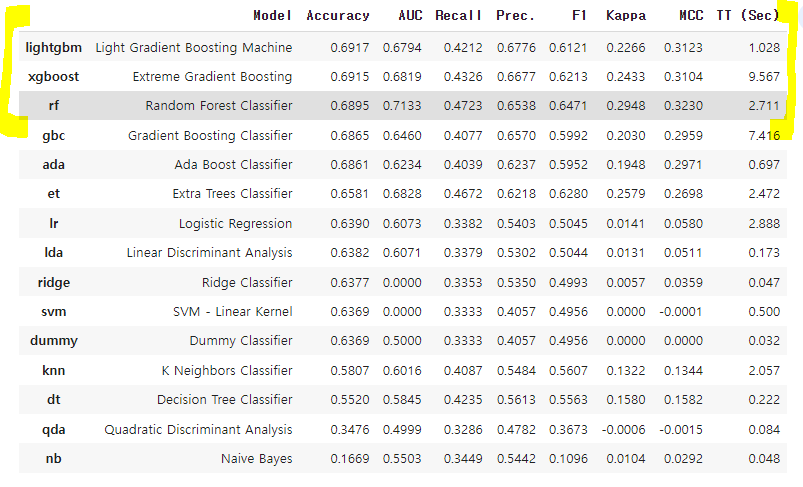

In [4]:
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix, precision_recall_curve


### 모델 훈련

In [5]:
# LGBM
model = LGBMClassifier( random_state=0) 

model.fit(x_train_transformed, y_train)


y_pred = model.predict_proba(x_test_transformed) 
print("{} Training set 정확도: {:.4f}".format("LGBM", model.score(x_train_transformed, y_train)))
print("{} Test set 정확도: {:.4f}".format("LGBM", model.score(x_test_transformed, y_test)))
print("log_loss: ", log_loss(y_test,y_pred))

LGBM Training set 정확도: 0.7191
LGBM Test set 정확도: 0.6976
log_loss:  0.7721801391181288


In [6]:
# XGBoost
model = XGBClassifier( random_state=0) 

model.fit(x_train_transformed, y_train)


y_pred = model.predict_proba(x_test_transformed) 
print("{} Training set 정확도: {:.4f}".format("XGB", model.score(x_train_transformed, y_train)))
print("{} Test set 정확도: {:.4f}".format("XGB", model.score(x_test_transformed, y_test)))
print("log_loss: ", log_loss(y_test,y_pred))


[11:42:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
LGBM Training set 정확도: 0.7617
LGBM Test set 정확도: 0.6945
log_loss:  0.7791348706074964


In [20]:
# Randomforest
model = RandomForestClassifier( random_state=0) 

model.fit(x_train_transformed, y_train)


y_pred = model.predict_proba(x_test_transformed) 
print("{} Training set 정확도: {:.4f}".format("LGBM", model.score(x_train_transformed, y_train)))
print("{} Test set 정확도: {:.4f}".format("LGBM", model.score(x_test_transformed, y_test)))
print("log_loss: ", log_loss(y_test,y_pred))

LGBM Training set 정확도: 0.9731
LGBM Test set 정확도: 0.6712
log_loss:  1.2323109140064188


## 모델 성능 개선

- 그리드 서치 + kfold
- 모델 스태킹

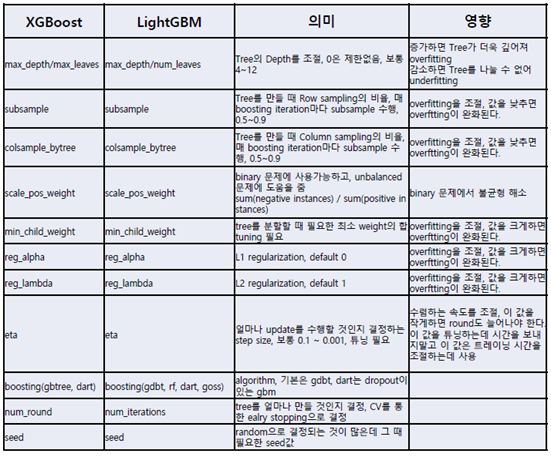

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

### 하이퍼파리미터 튜닝
- 그리드서치 best_param인 n_estimator: 300, learning_rate= 0.1 로 고정한채로 다른 파라미터 튜닝
<br>


max_depth = 5: 보통 4-6 를 시작점으로 함

min_child_weight = 1 

gamma = 0 

subsample, colsample_bytree = 0.8 : 보통 0.5 - 0.9로 시작

scale_pos_weight = 1

In [33]:
# n_estimators 
accuracy_list = []
estimator_list = [ i for i in range(100,1001,100)]

for estimator in estimator_list :
    xgb_model = xgb.XGBClassifier( n_estimators= estimator, seed=0)
    xgb_pred = xgb_model.fit(x_train_transformed, y_train).predict(x_test_transformed)

    xgb_accuracy = accuracy_score(y_test, xgb_pred) 
    accuracy_list.append(xgb_accuracy)
    
xgb_df = pd.DataFrame({'tree depth':estimator_list, 'accuracy':accuracy_list})



[16:01:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:01:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:01:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:01:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

,tree depth,accuracy
0,100,0.696388
1,200,0.692762
2,300,0.689405
3,400,0.684974
4,500,0.682422


In [42]:
# learning_rate 
accuracy_list = []
learning_list = [ 0.1, 0.01, 0.001]

for learning_rate in learning_list :
    xgb_model = xgb.XGBClassifier( learning_rate= learning_rate, seed=0)
    xgb_pred = xgb_model.fit(x_train_transformed, y_train).predict(x_test_transformed)

    xgb_accuracy = accuracy_score(y_test, xgb_pred) 
    accuracy_list.append(xgb_accuracy)
    
xgb_df = pd.DataFrame({'tree depth':learning_list, 'accuracy':accuracy_list})


[17:16:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [43]:
xgb_df

,tree depth,accuracy
0,0.100,0.691554
1,0.010,0.686988
2,0.001,0.687794


In [44]:
# 그리드 서치 XGBoost/ (learning_rate, n_estimators )

xgb_clf = XGBClassifier()

param_grid = { 
            "learning_rate":[0.1, 0.01, 0.001],
            "n_estimators":[100, 200, 300]
              }

grid = GridSearchCV(xgb_clf, param_grid, refit=True, verbose=0)

grid.fit(x_train_transformed, y_train)
#gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

[17:16:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[17:19:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:19:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:19:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:19:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
            

In [45]:
print('The best parameters are ', grid.best_params_)

The best parameters are  {'learning_rate': 0.1, 'n_estimators': 300}


#### max_depth와 min_child_weight를 튜닝
- max_depth: tree의 depth를 조절, 0은 제한없음, 보통 4~12
- min_child_weight: tree를 분할할 때 필요한 최소 weight의 합

In [ ]:
param_test1 = {
 'max_depth':range(3,10,3),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=300, 
                                                  max_depth=5, 
                                                  min_child_weight=1, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  objective = 'multi:softprob',
                                                  colsample_bytree=0.8,
                                                  nthread=-1, 
                                                  scale_pos_weight=1, seed=0),
param_grid = param_test1, scoring='accuracy',n_jobs=-1, cv=5, verbose=5)

gsearch1.fit(x_train_transformed, y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [ ]:
grid_df = pd.DataFrame(gsearch1.cv_results_)
grid_df.loc[:, ['mean_test_score', "params"]]

#### gamma 튜닝


In [ ]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=300, 
                                                  max_depth=6, 
                                                  min_child_weight=1, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  objective = 'multi:softprob',
                                                  colsample_bytree=0.8,
                                                  nthread=-1, 
                                                  scale_pos_weight=1, seed=0), 
                        param_grid = param_test2, scoring='accuracy', n_jobs=-1, cv=5)
gsearch2.fit(x_train_transformed, y_train)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

In [ ]:
grid_df = pd.DataFrame(gsearch2.cv_results_)
grid_df.loc[:, ['mean_test_score', "params"]]

#### subsample / colsample_bytree 튜닝
- subsample:   tree를 만들 때 row sampling의 비율, 매 boosting iteration마다 subsample수행, 0.5~0.9
- colsample_bytree:   tree를 만들 때 column sampling의 비율, 매 boosting iteration마다 subsample수행, 0.5~0.9

In [ ]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=300, 
                                                  max_depth=6,
                                                  min_child_weight=1, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'multi:softprob', 
                                                  thread=-1, 
                                                  scale_pos_weight=1,
                                                  seed=0), 
                        param_grid = param_test3, scoring='accuracy', n_jobs=-1, cv=5, verbose=10)
gsearch3.fit(x_train_transformed, y_train)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
grid_df3 = pd.DataFrame(gsearch3.cv_results_)
grid_df3.loc[:, ['mean_test_score', "params"]]

#### reg_alpha / reg_lambda 튜닝
- L1 regularization, default 0
- L2 regularization, default 1 

In [ ]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=300, 
                                                  max_depth=6,
                                                  min_child_weight=1, 
                                                  gamma=0, 
                                                  subsample=0.76, 
                                                  colsample_bytree=0.6,
                                                  objective= 'multi:softprob', 
                                                  thread=-1, 
                                                  scale_pos_weight=1,
                                                  seed=0), 
                        param_grid = param_test5, scoring='accuracy', n_jobs=-1, cv=5, verbose=10)
gsearch5.fit(x_train_transformed, y_train)
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_


In [ ]:
grid_df5 = pd.DataFrame(gsearch5.cv_results_)
grid_df5.loc[:, ['mean_test_score', "params"]]

### 최종 파라미터 

In [7]:
# 최고 성능 파라미터 값

model = XGBClassifier(learning_rate =0.1, 
                      n_estimators=300, 
                      max_depth=6,
                      min_child_weight=1, 
                      gamma=0, 
                      subsample=0.6, 
                      colsample_bytree=0.6,
                      objective= 'multi:softprob', 
                      thread=-1, 
                      scale_pos_weight=1,
                      reg_alpha=1e-5,
                      seed=0)
model.fit(x_train_transformed, y_train) 

y_pred = model.predict_proba(x_test_transformed) # 예측 라벨
    
print("{} Training set 정확도: {:.4f}".format("XGB", model.score(x_train_transformed, y_train)))
print("{} Test set 정확도: {:.4f}".format("XGB", model.score(x_test_transformed, y_test)))
print("log_loss: ", log_loss(y_test,y_pred))

[11:42:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight", "thread" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:42:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB Training set 정확도: 0.7623
XGB Test set 정확도: 0.6960
log_loss:  0.7674070726589871


### 학습률 조정

In [9]:
param_test1 = {
 'learning_rate':[0.01, 0.05, 0.1, 0.15, 0.2]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=300, 
                                                  max_depth=6,
                                                  min_child_weight=1, 
                                                  gamma=0, 
                                                  subsample=0.6, 
                                                  colsample_bytree=0.6,
                                                  objective= 'multi:softprob', 
                                                  thread=-1, 
                                                  scale_pos_weight=1,
                                                  reg_alpha=1e-5,
                                                  seed=0),
param_grid = param_test1, scoring='accuracy',n_jobs=-1, cv=5, verbose=5)

gsearch1.fit(x_train_transformed, y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[11:54:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight", "thread" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:54:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'mean_fit_time': array([69.40354414, 65.5300117 , 62.36111336, 62.50792875, 52.21468801]),
  'std_fit_time': array([ 0.68376997,  2.73640175,  0.16228973,  0.16921224, 20.03808327]),
  'mean_score_time': array([0.04621577, 0.05181484, 0.04849749, 0.04811115, 0.03272767]),
  'std_score_time': array([0.00465517, 0.00647142, 0.0069022 , 0.00383737, 0.00921756]),
  'param_learning_rate': masked_array(data=[0.01, 0.05, 0.1, 0.15, 0.2],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'learning_rate': 0.01},
   {'learning_rate': 0.05},
   {'learning_rate': 0.1},
   {'learning_rate': 0.15},
   {'learning_rate': 0.2}],
  'split0_test_score': array([0.68852092, 0.6923249 , 0.69501007, 0.69031103, 0.68829716]),
  'split1_test_score': array([0.68845121, 0.69449418, 0.69874664, 0.69180842, 0.69180842]),
  'split2_test_score': array([0.68554163, 0.69180842, 0.69247986, 0.68979409, 0.69136079]),
  'split3_test_score': arra

In [10]:
grid_df6 = pd.DataFrame(gsearch1.cv_results_)
grid_df6.loc[:, ['mean_test_score', "params"]]

,mean_test_score,params
0,0.687883,{'learning_rate': 0.01}
1,0.692628,{'learning_rate': 0.05}
2,0.695403,{'learning_rate': 0.1}
3,0.691867,{'learning_rate': 0.15}
4,0.688913,{'learning_rate': 0.2}


In [8]:
# 그리드서치 결과 in KFold
s_kf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 0)

accuracy_ = []

for train_index, test_index in s_kf.split(train_data, train_target):
    X_train, X_test = train_data.iloc[train_index], train_data.iloc[test_index]
    y_train, y_test = train_target.iloc[train_index], train_target.iloc[test_index]

    x_train_transformed , x_test_transformed = pipe_processing(X_train, X_test)

    model = XGBClassifier(learning_rate =0.1, 
                          n_estimators=300, 
                          max_depth=6,
                          min_child_weight=1, 
                          gamma=0, 
                          subsample=0.6, 
                          colsample_bytree=0.6,
                          objective= 'multi:softprob', 
                          thread=-1, 
                          scale_pos_weight=1,
                          reg_alpha=1e-5,
                          seed=0)
    model.fit(x_train_transformed, y_train) 

    y_pred = model.predict(x_test_transformed)
    accuracy_.append(accuracy_score(y_test, y_pred)) 
    
print("각 분할의 정확도 기록 :", accuracy_)
print("평균 정확도 :", np.mean(accuracy_))   

[11:45:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight", "thread" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:45:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:47:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight", "thread" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings b

### 모델 스태킹

In [11]:
# 모델 스태킹
from vecstack import stacking


models = [ 
GradientBoostingClassifier(n_estimators=200, random_state=0), 
LGBMClassifier(n_estimators=200, random_state=0),
XGBClassifier(learning_rate =0.1, 
              n_estimators=300, 
              max_depth=6,
              min_child_weight=1, 
              gamma=0, 
              subsample=0.6, 
              colsample_bytree=0.6,
              objective= 'multi:softprob', 
              thread=-1, 
              scale_pos_weight=1,
              reg_alpha=1e-5,
              seed=0)] 

S_train, S_test = stacking(models, 
                       x_train_transformed, y_train, x_test_transformed, 
                       regression = False, 
                       metric = accuracy_score, 
                       n_folds = 10, stratified = True, shuffle = True, 
                       random_state = 0, verbose = 0)


model = XGBClassifier(learning_rate =0.1, 
                      n_estimators=300, 
                      max_depth=6,
                      min_child_weight=1, 
                      gamma=0, 
                      subsample=0.6, 
                      colsample_bytree=0.6,
                      objective= 'multi:softprob', 
                      thread=-1, 
                      scale_pos_weight=1,
                      reg_alpha=1e-5,
                      seed=0)

model = model.fit(S_train, y_train)  
y_pred = model.predict_proba(S_test)


[11:59:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight", "thread" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:59:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:59:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight", "thread" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings b

In [12]:
print("Accuracy on Training set: {:.4f}".format(model.score(S_train, y_train)))
print("Accuracy on Test set: {:.4f}".format(model.score(S_test, y_test)))

Accuracy on Training set: 0.6943
Accuracy on Test set: 0.6922


In [13]:
print("log_loss:", log_loss(y_test,y_pred))

log_loss: 0.80981682850938
